In [203]:
# Database & File IO
from pymongo import MongoClient
import researchpy as rp
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
import plotly.express as px
# import json5 as json

# Standard Data Manipulation
from collections import defaultdict
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
pd.set_option('display.max_colwidth', None)  # We want to see all data
from statistics import mean, median
import seaborn as sns
import numpy as np
from sklearn import preprocessing
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import json


# scipy
from scipy.stats import boxcox
from scipy.stats import skew

# Tracking Time
from time import time

In [87]:
# Connect to the database
client = MongoClient()
db = client['JiraRepos']

# Data Extraction

- Extracting all the columns as indicated in our research paper from MongoDB using Pymongo 

In [88]:
# function to extract data from mongo
def extract_col(data, key):
    try:
        result = data['fields'][key]
    except:
        result = -1
    
    if not result:
        result = -1
        
    return result

In [89]:
# function to extract data from mongo
# can also search using the key and then iterate over - connection['db']['collection'].find({"key":{'$exists': True}})

def extract_othr_cols(data):

    # count number of subtasks 
    try:
        subtasks = len(list(data['fields']['subtasks']))        
    except:
        subtasks = 0


    # count number of comments 
    try:
        comments = len(list(data['fields']['comments']))        
    except:
        comments = 0


    # get authors and datetime for the comments
    try:
        comment_authors = []
        comment_datetime = []
        updated_author = []
        updated_datetime = []
        comments_ls = list(data['fields']['comments']) 
        for comment in comments_ls:
            if "key" in comment['author'].keys():
                comment_authors.append(comment['author']['key'])
                comment_datetime.append(comment['created'])
                updated_author.append(comment['updateAuthor']['key'])
                updated_datetime.append(comment['updated'])
            else:
                comment_authors.append(comment['author']['accountId'])
                comment_datetime.append(comment['created'])
                updated_author.append(comment['updateAuthor']['accountId'])
                updated_datetime.append(comment['updated'])
    except:
        comment_authors = []
        comment_datetime = []
        updated_author = []
        updated_datetime = []


    # get inwords outwords count from issues links
    try:
        issue_link_ls = list(data['fields']['issuelinks'])
        issue_link_count = len(issue_link_ls)
        outward_count = 0
        inward_count = 0
        for issue in issue_link_ls:
            if "outwardIssue" in issue.keys():
                outward_count+=1
            if "inwardIssue" in issue.keys():
                inward_count+=1
    except:
        issue_link_count = 0
        outward_count = 0
        inward_count = 0



    if not comments:
        comments = 0
    
    if not issue_link_count:
        issue_link_count = 0

    if not outward_count:
        outward_count = 0

    if not inward_count:
        inward_count = 0






    # extract fields 
    try:
        project_name = data['fields']['project']['name']
    except:
        project_name = - 1
    try:
        issue_name = data['fields']['issuetype']['name']
    except:
        issue_name = - 1
    try:
        priority = data['fields']['priority']['name']
    except:
        priority = - 1
    try:
        votes = data['fields']['votes']['votes']
    except:
        votes = - 1
    try:
        watches = data['fields']['watches']['watchCount']
    except:
        watches = - 1
    try:
        log_change_count = data['changelog']['total']
    except:
        log_change_count = - 1



    if not project_name:
        project_name = -1

    if not issue_name:
        issue_name = -1

    if not priority:
        priority = -1

    if not votes:
        votes = -1

    if not watches:
        watches = -1

    if not issue_name:
        issue_name = -1

    if not log_change_count:
        log_change_count = -1





    # extract names (sometimes it's key sometimes its accountId)
    try:
        if "key" in data['fields']['assignee'].keys():
            assignee_name = data['fields']['assignee']['key']
            assignee_active_status = data['fields']['assignee']['active']
        else:
            assignee_name = data['fields']['assignee']['accountId']
            assignee_active_status = data['fields']['assignee']['active']
    except:
        assignee_name = - 1
        assignee_active_status=-1

    try:
        if "key" in data['fields']['creator'].keys():
            creator_name = data['fields']['creator']['key']
            creator_active_status = data['fields']['creator']['active']
        else:
            creator_name = data['fields']['creator']['accountId']
            creator_active_status = data['fields']['creator']['active']   
    except:
        creator_name = - 1
        creator_active_status = -1

    try:
        if "key" in data['fields']['reporter'].keys():
            reporter_name = data['fields']['reporter']['key']
            reporter_active_status = data['fields']['reporter']['active']
        else:
            reporter_name = data['fields']['reporter']['accountId']
            reporter_active_status = data['fields']['reporter']['active']
    except:
        reporter_name = - 1
        reporter_active_status = -1



    if not assignee_name:
        assignee_name = -1

    if not assignee_active_status:
        assignee_active_status = -1

    if not creator_name:
        creator_name = -1

    if not issue_name:
        issue_name = -1

    if not creator_active_status:
        creator_active_status = -1

    if not reporter_name:
        reporter_name = -1

    if not reporter_active_status:
        reporter_active_status = -1

    
    return [subtasks, comments, comment_authors, comment_datetime, updated_author, updated_datetime, issue_link_count, outward_count, inward_count,  project_name, issue_name, priority, votes, watches, log_change_count, assignee_name, assignee_active_status, creator_name, creator_active_status, reporter_name, reporter_active_status]

In [91]:
# extract these attributes for different software projects 
field_attr = ['timespent','timeestimate','created','updated','resolutiondate','duedate','labels']

# other attributes (which require different exrtaction way)
othr_attr = ['subtasks','comments', 'comment_authors', 'comment_datetime', 'updated_author', 'updated_datetime', 'issue_link_count', 'outward_count', 'inward_count', 'project_name','issue_name', 'priority', 'votes', 'watches', 'log_change_count', 'assignee_id', 'assignee_active_status', 'creator_id', 'creator_active_status', 'reporter_id', 'reporter_active_status']

# list to store rows
r1_df_ls = []

for coll in db.list_collection_names():
    # if coll != "Hyperledger":
    #     continue
    print(coll)
    for data in db[coll].find():
        issue_id = data['id']
        othr_attr_values  = extract_othr_cols(data)
        attr_results = []
        for attr in field_attr:
            result = extract_col(data,attr)
            attr_results.append(result)

        feture_ls = [coll,issue_id] + attr_results + othr_attr_values
        r1_df_ls.append(feture_ls)
    

RedHat
Sonatype
JiraEcosystem
Hyperledger
JFrog
Mindville
MariaDB
IntelDAOS
Qt
Spring
Jira
Sakai
MongoDB
Apache
Mojang
SecondLife


In [93]:
# creating dataframe
column_names = ['repo_name','id'] + field_attr + othr_attr
r1_df = pd.DataFrame(r1_df_ls, columns=column_names).replace(-1,np.nan).replace('-1',np.nan)
r1_df.to_csv('../data/processed/raw_data_v2.csv',index=False)
r1_df.head()

,repo_name,id,timespent,timeestimate,created,updated,resolutiondate,duedate,labels,subtasks,...,priority,votes,watches,log_change_count,assignee_id,assignee_active_status,creator_id,creator_active_status,reporter_id,reporter_active_status
0,RedHat,14386212,NaN,NaN,2021-12-10T16:24:43.000+0000,2021-12-10T16:24:43.000+0000,NaN,NaN,NaN,0,...,Major,NaN,1.0,NaN,NaN,NaN,pmm,True,pmm,True
1,RedHat,14362586,NaN,NaN,2021-11-26T11:16:31.000+0000,2021-11-26T14:16:52.000+0000,2021-11-26T14:16:44.000+0000,NaN,NaN,0,...,Major,NaN,NaN,7.0,flavia.rainone,True,flavia.rainone,True,flavia.rainone,True
2,RedHat,14362585,NaN,NaN,2021-11-26T11:15:05.000+0000,2021-11-26T13:53:57.000+0000,2021-11-26T13:53:57.000+0000,NaN,NaN,0,...,Major,NaN,NaN,6.0,flavia.rainone,True,flavia.rainone,True,flavia.rainone,True
3,RedHat,14362245,NaN,NaN,2021-11-25T19:23:29.000+0000,2021-11-26T12:38:58.000+0000,2021-11-26T12:05:18.000+0000,NaN,NaN,0,...,Major,NaN,NaN,5.0,flavia.rainone,True,flavia.rainone,True,flavia.rainone,True
4,RedHat,14265579,NaN,NaN,2021-09-25T22:12:44.000+0000,2021-09-25T22:16:32.000+0000,NaN,NaN,NaN,0,...,Major,NaN,NaN,1.0,flavia.rainone,True,flavia.rainone,True,flavia.rainone,True


# Load data and preprocess 

- loaded the raw data extraced above and only kept the data where timeestimate and timespent are not null 

In [4]:
# read saved data as csv
r1_df = pd.read_csv('../data/processed/raw_data_v2.csv')
print(r1_df.shape)
r1_df.head()

/var/folders/5_/kbn_rbxx7r58wh4vqxvfhny40000gn/T/ipykernel_70294/3431658782.py:2: DtypeWarning: Columns (7,20,24,25,27,29) have mixed types. Specify dtype option on import or set low_memory=False.
  r1_df = pd.read_csv('../data/processed/raw_data_v2.csv')


(2686282, 30)


,repo_name,id,timespent,timeestimate,created,updated,resolutiondate,duedate,labels,subtasks,...,priority,votes,watches,log_change_count,assignee_id,assignee_active_status,creator_id,creator_active_status,reporter_id,reporter_active_status
0,RedHat,14386212,NaN,NaN,2021-12-10T16:24:43.000+0000,2021-12-10T16:24:43.000+0000,NaN,NaN,NaN,0,...,Major,NaN,1.0,NaN,NaN,NaN,pmm,True,pmm,True
1,RedHat,14362586,NaN,NaN,2021-11-26T11:16:31.000+0000,2021-11-26T14:16:52.000+0000,2021-11-26T14:16:44.000+0000,NaN,NaN,0,...,Major,NaN,NaN,7.0,flavia.rainone,True,flavia.rainone,True,flavia.rainone,True
2,RedHat,14362585,NaN,NaN,2021-11-26T11:15:05.000+0000,2021-11-26T13:53:57.000+0000,2021-11-26T13:53:57.000+0000,NaN,NaN,0,...,Major,NaN,NaN,6.0,flavia.rainone,True,flavia.rainone,True,flavia.rainone,True
3,RedHat,14362245,NaN,NaN,2021-11-25T19:23:29.000+0000,2021-11-26T12:38:58.000+0000,2021-11-26T12:05:18.000+0000,NaN,NaN,0,...,Major,NaN,NaN,5.0,flavia.rainone,True,flavia.rainone,True,flavia.rainone,True
4,RedHat,14265579,NaN,NaN,2021-09-25T22:12:44.000+0000,2021-09-25T22:16:32.000+0000,NaN,NaN,NaN,0,...,Major,NaN,NaN,1.0,flavia.rainone,True,flavia.rainone,True,flavia.rainone,True


In [5]:
# check null percentage
r1_df.isnull().sum() * 100 / len(r1_df)

repo_name                  0.000000
id                         0.000000
timespent                 97.072757
timeestimate              98.726902
created                    0.000000
updated                    0.000000
resolutiondate            14.075477
duedate                   99.507758
labels                    78.679267
subtasks                   0.000000
comments                   0.000000
comment_authors            0.000000
comment_datetime           0.000000
updated_author             0.000000
updated_datetime           0.000000
issue_link_count           0.000000
outward_count              0.000000
inward_count               0.000000
project_name               0.000000
issue_name                 0.000000
priority                  21.737442
votes                     88.202988
watches                   23.465407
log_change_count           2.527918
assignee_id               40.813623
assignee_active_status    45.734476
creator_id                 0.305887
creator_active_status      7

In [6]:
# # perfrom basic analysis 
# profile = ProfileReport(r1_df, title="Pandas Profiling Report")
# profile

In [7]:
# keep data only where timeestimate and timespent are not null
r1_df_mod = r1_df.fillna(-1)
r1_df_clean = r1_df_mod[(r1_df_mod['timeestimate']!=-1) & (r1_df_mod['timespent']!=-1)].reset_index(drop=True)
print(r1_df_clean.shape)
r1_df_clean.head()

(2480, 30)


,repo_name,id,timespent,timeestimate,created,updated,resolutiondate,duedate,labels,subtasks,...,priority,votes,watches,log_change_count,assignee_id,assignee_active_status,creator_id,creator_active_status,reporter_id,reporter_active_status
0,RedHat,13227914,864000.0,288000.0,2021-01-08T16:38:15.000+0000,2021-03-16T14:04:18.000+0000,2021-02-23T16:49:41.000+0000,2021-02-27,-1,0,...,Blocker,-1.0,1.0,28.0,chenw2020,True,chenw2020,True,chenw2020,True
1,RedHat,12374223,3660.0,3600.0,2008-12-30T20:15:24.000+0000,2013-06-10T18:21:50.000+0000,2013-02-18T08:29:58.000+0000,-1,-1,0,...,Major,-1.0,-1.0,8.0,fdg,-1,fdg,-1,fdg,-1
2,RedHat,12672269,43200.0,14400.0,2017-01-20T06:23:09.000+0000,2017-12-06T11:52:42.000+0000,2017-02-24T10:15:35.000+0000,-1,-1,0,...,Major,-1.0,1.0,10.0,thofman,True,thofman,True,thofman,True
3,RedHat,12628931,600.0,3000.0,2016-06-01T07:26:47.000+0000,2021-10-24T06:35:10.000+0000,2016-07-22T11:27:49.000+0000,-1,['downstream_dependency'],0,...,Trivial,-1.0,2.0,12.0,iweiss,True,iweiss,True,iweiss,True
4,RedHat,12461055,7200.0,50400.0,2012-03-08T08:17:09.000+0000,2016-02-10T05:34:24.000+0000,2016-02-10T05:34:24.000+0000,-1,-1,0,...,Major,1.0,2.0,12.0,-1,-1,ozizka,-1,ozizka,-1


In [8]:
# save filtered data
r1_df_clean_mod = r1_df_clean.replace(-1,np.nan).replace('-1',np.nan)
r1_df_clean_mod.to_csv('../data/processed/clean_data_v2.csv',index=False)

# Research Question 1  
- calculated % error in estimated time with respect to original time -> (r1['timeestimate'] - r1['timespent'])/r1['timespent']
- divide data in over, under and on time estimates and removed oulier (2 outliers)
- checked if overestimated and underestimated data(timespent andtimeestimate) was notmally distributed or not, it was not
- checked which transformation will give least skewness, it was log transformation
- applied log transformation
- perfromed t-test for both overestimated and underestimated issues

In [429]:
r1_df_clean_mod = pd.read_csv('../data/processed/clean_data_v2.csv')
r1_df_clean_mod.head()

,repo_name,id,timespent,timeestimate,created,updated,resolutiondate,duedate,labels,subtasks,...,priority,votes,watches,log_change_count,assignee_id,assignee_active_status,creator_id,creator_active_status,reporter_id,reporter_active_status
0,RedHat,13227914,864000.0,288000.0,2021-01-08T16:38:15.000+0000,2021-03-16T14:04:18.000+0000,2021-02-23T16:49:41.000+0000,2021-02-27,NaN,0,...,Blocker,NaN,1.0,28.0,chenw2020,True,chenw2020,True,chenw2020,True
1,RedHat,12374223,3660.0,3600.0,2008-12-30T20:15:24.000+0000,2013-06-10T18:21:50.000+0000,2013-02-18T08:29:58.000+0000,NaN,NaN,0,...,Major,NaN,NaN,8.0,fdg,NaN,fdg,NaN,fdg,NaN
2,RedHat,12672269,43200.0,14400.0,2017-01-20T06:23:09.000+0000,2017-12-06T11:52:42.000+0000,2017-02-24T10:15:35.000+0000,NaN,NaN,0,...,Major,NaN,1.0,10.0,thofman,True,thofman,True,thofman,True
3,RedHat,12628931,600.0,3000.0,2016-06-01T07:26:47.000+0000,2021-10-24T06:35:10.000+0000,2016-07-22T11:27:49.000+0000,NaN,['downstream_dependency'],0,...,Trivial,NaN,2.0,12.0,iweiss,True,iweiss,True,iweiss,True
4,RedHat,12461055,7200.0,50400.0,2012-03-08T08:17:09.000+0000,2016-02-10T05:34:24.000+0000,2016-02-10T05:34:24.000+0000,NaN,NaN,0,...,Major,1.0,2.0,12.0,NaN,NaN,ozizka,NaN,ozizka,NaN


In [430]:
# # perfrom basic analysis over filtered data
# profile = ProfileReport(r1_df_clean_mod, title="Pandas Profiling Report")
# profile

In [431]:
r1 = r1_df_clean_mod[['timespent', 'timeestimate']]
r1['estimation_error'] = (r1['timeestimate'] - r1['timespent'])/r1['timespent']
r1.head()

/var/folders/5_/kbn_rbxx7r58wh4vqxvfhny40000gn/T/ipykernel_70294/2076466643.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,timespent,timeestimate,estimation_error
0,864000.0,288000.0,-0.666667
1,3660.0,3600.0,-0.016393
2,43200.0,14400.0,-0.666667
3,600.0,3000.0,4.000000
4,7200.0,50400.0,6.000000


In [432]:
# check for outlier
px.box(r1['estimation_error'])

In [436]:
# 2 values are way off so removing those
r1 = r1[r1['estimation_error']<4000]

In [437]:
# check for outlier
px.box(r1['estimation_error'])

In [438]:
r1['estimate_class'] = np.where(r1['estimation_error'] == 0,
                                       'accurate',
                                       np.where(r1['estimation_error'] < 0,
                                                'underestimated',
                                                'overestimated'
                                                )
                                       )

In [439]:
r1.head()

,timespent,timeestimate,estimation_error,estimate_class
0,864000.0,288000.0,-0.666667,underestimated
1,3660.0,3600.0,-0.016393,underestimated
2,43200.0,14400.0,-0.666667,underestimated
3,600.0,3000.0,4.000000,overestimated
4,7200.0,50400.0,6.000000,overestimated


In [440]:
r1_overestimated = r1[r1['estimate_class'] == 'overestimated'].iloc[:,:2]
r1_overestimated.head()

,timespent,timeestimate
3,600.0,3000.0
4,7200.0,50400.0
5,10800.0,18000.0
10,3600.0,7200.0
14,10800.0,18000.0


In [441]:
r1_underestimated = r1[r1['estimate_class'] == 'underestimated'].iloc[:,:2]
r1_underestimated.head()

,timespent,timeestimate
0,864000.0,288000.0
1,3660.0,3600.0
2,43200.0,14400.0
6,10800.0,3600.0
7,100800.0,14400.0


array([[<AxesSubplot:title={'center':'timespent'}>,
        <AxesSubplot:title={'center':'timeestimate'}>]], dtype=object)

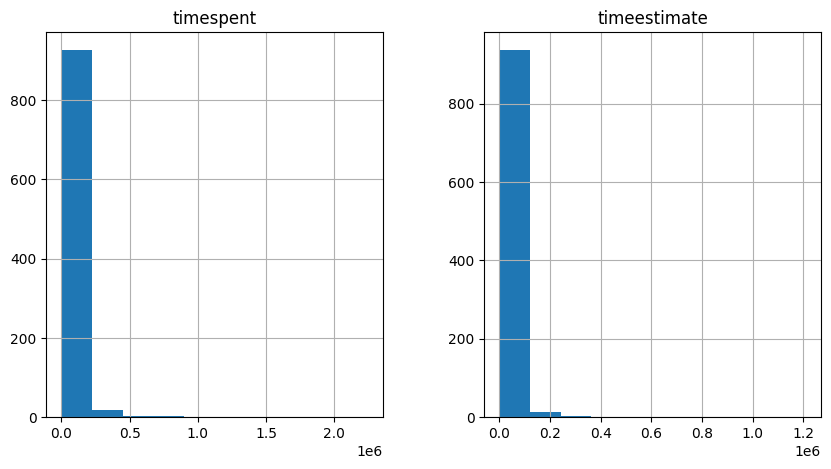

In [442]:
# check data distribution
r1_underestimated.hist(figsize=(10,5))

**NOTE** - Data is not normally distributed

In [443]:
# Dataframe subset, single or multi columns as train, type is the transformation type
# scalling function
def scalling(train, type='ss'):
    if type=='ss':
        std_scaler = preprocessing.StandardScaler()
        std_scaler.fit(train)
        train_transform = std_scaler.transform(train)
        df_train_transform = pd.DataFrame(train_transform,columns = train.columns)
        df_train_transform = df_train_transform.set_index(train.index)
        return std_scaler,df_train_transform
    if type=='mms':
        mms_scaler = preprocessing.MinMaxScaler()
        mms_scaler.fit(train)
        train_transform = mms_scaler.transform(train)
        df_train_transform = pd.DataFrame(train_transform,columns = train.columns)
        df_train_transform = df_train_transform.set_index(train.index)
        return mms_scaler,df_train_transform
    if type=='bx':
        pt = preprocessing.PowerTransformer(method='box-cox')
        train_nonzero = train.replace(0,0.000001)
        pt.fit(train_nonzero)
        train_transform = pt.transform(train_nonzero)
        df_train_transform = pd.DataFrame(train_transform,columns = train.columns)
        df_train_transform = df_train_transform.set_index(train.index)
        return pt, df_train_transform

In [444]:
# to plot the skewness, although skewness is not the only factor to check the goodness of fit
def plot_dist(train_numeric):
    # avg_skewness = (np.abs(np.round(skew(train_numeric),4)).sum())/4
    skewness = np.abs(np.round(skew(train_numeric),4))
    avg_skewness = (np.abs(np.round(skew(train_numeric),4)).sum())/4
    print("The skewness of the data is -",skewness)
    print("The average skewness is - ",avg_skewness)
    train_numeric.plot.kde(subplots=True,layout=(4,3),sharex=False,figsize=(12,12));

In [445]:
# There are different transformations to convert data to normal distribution 
# There are different functions to fit data to normal distribution, we can try and check the which fits the best
def apply_dist_func(train_numeric):
    # original distribution
    print("original distribution")
    plot_dist(train_numeric)

    # log transformation
    print("log transformation")
    log_transform = np.log1p(train_numeric)
    plot_dist(log_transform)

    # square root transformation
    print("Square root transformation")
    sqt_transform = train_numeric**(1/2)
    plot_dist(sqt_transform)

    # resiprocal transformation
    print("resiprocal transformation")
    res_transform = 1/(train_numeric.replace(0,0.00001))
    plot_dist(res_transform)

    # # box cox transformation
    # print("box-cox transformation")
    # scaler, bx_transform  = scalling(train_numeric,'bx')
    # plot_dist(bx_transform)

original distribution
The skewness of the data is - [24.937  10.6056]
The average skewness is -  8.88565
log transformation
The skewness of the data is - [0.4642 0.1889]
The average skewness is -  0.163275
Square root transformation
The skewness of the data is - [7.3505 3.1504]
The average skewness is -  2.625225
resiprocal transformation
The skewness of the data is - [8.9539 7.2787]
The average skewness is -  4.05815


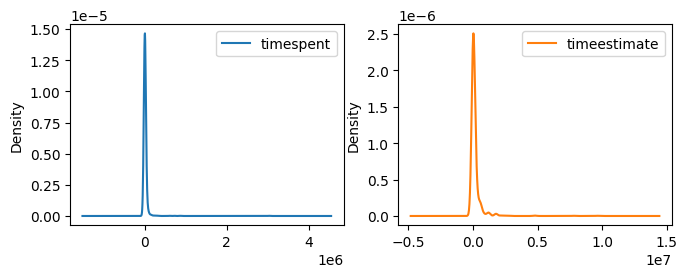

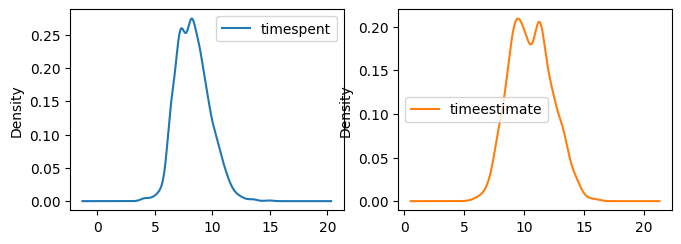

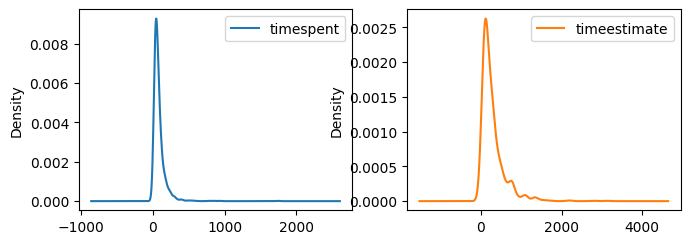

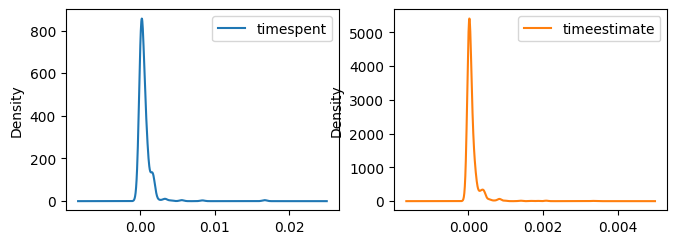

In [446]:
# applying normal distribution function
apply_dist_func(r1_overestimated)

In [447]:
# use log transformation
r1_overestimated = np.log1p(r1_overestimated)
r1_underestimated = np.log1p(r1_underestimated)

### t-test for overestimated

In [448]:
summary, results = rp.ttest(group1= r1_overestimated['timespent'], group1_name= "timespent",
                            group2= r1_overestimated['timeestimate'], group2_name= "timeestimate")
summary

/opt/homebrew/anaconda3/envs/ml/lib/python3.10/site-packages/researchpy/ttest.py:38: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,timespent,1140.0,8.306906,1.427116,0.042268,8.223975,8.389837
1,timeestimate,1140.0,10.539238,1.730293,0.051247,10.438689,10.639787
2,combined,2280.0,9.423072,1.939216,0.040612,9.343431,9.502713


In [449]:
results

,Independent t-test,results
0,Difference (timespent - timeestimate) =,-2.2323
1,Degrees of freedom =,2278.0000
2,t =,-33.6049
3,Two side test p value =,0.0000
4,Difference < 0 p value =,0.0000
5,Difference > 0 p value =,1.0000
6,Cohen's d =,-1.4076
7,Hedge's g =,-1.4071
8,Glass's delta1 =,-1.5642
9,Point-Biserial r =,-0.5757


### t-test for underestimated

In [450]:
summary, results = rp.ttest(group1= r1_underestimated['timespent'], group1_name= "timespent",
                            group2= r1_underestimated['timeestimate'], group2_name= "timeestimate")
summary

/opt/homebrew/anaconda3/envs/ml/lib/python3.10/site-packages/researchpy/ttest.py:38: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,timespent,954.0,9.782791,1.283920,0.041568,9.701215,9.864367
1,timeestimate,954.0,8.550599,1.349446,0.043690,8.464859,8.636338
2,combined,1908.0,9.166695,1.453820,0.033283,9.101420,9.231970


In [451]:
results

,Independent t-test,results
0,Difference (timespent - timeestimate) =,1.2322
1,Degrees of freedom =,1906.0000
2,t =,20.4325
3,Two side test p value =,0.0000
4,Difference < 0 p value =,1.0000
5,Difference > 0 p value =,0.0000
6,Cohen's d =,0.9355
7,Hedge's g =,0.9352
8,Glass's delta1 =,0.9597
9,Point-Biserial r =,0.4239


### A simple annova test to check if there is a significance difference between accurate, underestimated, overestimated
- Ignore this if not useful

In [452]:
# anova test for 
from scipy.stats import f_oneway
 
# Performance when each of the engine
# oil is applied
performance1 = list(r1[r1['estimate_class']=='underestimated']['estimation_error'])
performance2 = list(r1[r1['estimate_class']=='overestimated']['estimation_error'])
performance3 = list(r1[r1['estimate_class']=='accurate']['estimation_error'])
 
# Conduct the one-way ANOVA
f_oneway(performance1, performance2, performance3)

F_onewayResult(statistic=69.14811437045871, pvalue=6.0030216365442976e-30)

# Research Question 2

- calculated % error in estimated time with respect to original time -> (r2['timeestimate'] - r2['timespent'])/r2['timespent']
- divide data in over, under and on time estimates and removed oulier (2 outliers)
- remove perfect predictions (esimation error = 0)
- check null percentage
- remove cols with null values > 40%
- fill missing with most frequent (only 11% of priority data was missing) -> (missing value imputation)
- use random forest for feature importance -> identifying which features are important
- correlation analysis for numerical variables to quanitfy how they are impacting over/under estimations

In [455]:
r1_df_clean_mod = pd.read_csv('../data/processed/clean_data_v2.csv')
r1_df_clean_mod.head()

,repo_name,id,timespent,timeestimate,created,updated,resolutiondate,duedate,labels,subtasks,...,priority,votes,watches,log_change_count,assignee_id,assignee_active_status,creator_id,creator_active_status,reporter_id,reporter_active_status
0,RedHat,13227914,864000.0,288000.0,2021-01-08T16:38:15.000+0000,2021-03-16T14:04:18.000+0000,2021-02-23T16:49:41.000+0000,2021-02-27,NaN,0,...,Blocker,NaN,1.0,28.0,chenw2020,True,chenw2020,True,chenw2020,True
1,RedHat,12374223,3660.0,3600.0,2008-12-30T20:15:24.000+0000,2013-06-10T18:21:50.000+0000,2013-02-18T08:29:58.000+0000,NaN,NaN,0,...,Major,NaN,NaN,8.0,fdg,NaN,fdg,NaN,fdg,NaN
2,RedHat,12672269,43200.0,14400.0,2017-01-20T06:23:09.000+0000,2017-12-06T11:52:42.000+0000,2017-02-24T10:15:35.000+0000,NaN,NaN,0,...,Major,NaN,1.0,10.0,thofman,True,thofman,True,thofman,True
3,RedHat,12628931,600.0,3000.0,2016-06-01T07:26:47.000+0000,2021-10-24T06:35:10.000+0000,2016-07-22T11:27:49.000+0000,NaN,['downstream_dependency'],0,...,Trivial,NaN,2.0,12.0,iweiss,True,iweiss,True,iweiss,True
4,RedHat,12461055,7200.0,50400.0,2012-03-08T08:17:09.000+0000,2016-02-10T05:34:24.000+0000,2016-02-10T05:34:24.000+0000,NaN,NaN,0,...,Major,1.0,2.0,12.0,NaN,NaN,ozizka,NaN,ozizka,NaN


In [456]:
r1_df_clean_mod['estimation_error'] = (r1_df_clean_mod['timeestimate'] - r1_df_clean_mod['timespent']) / r1_df_clean_mod['timespent']
r1_df_clean_mod['estimate_class'] = np.where(r1_df_clean_mod['estimation_error'] == 0,
                                       'accurate',
                                       np.where(r1_df_clean_mod['estimation_error'] < 0,
                                                'underestimated',
                                                'overestimated'
                                                )
                                       )
r1_df_clean_mod.head()

,repo_name,id,timespent,timeestimate,created,updated,resolutiondate,duedate,labels,subtasks,...,watches,log_change_count,assignee_id,assignee_active_status,creator_id,creator_active_status,reporter_id,reporter_active_status,estimation_error,estimate_class
0,RedHat,13227914,864000.0,288000.0,2021-01-08T16:38:15.000+0000,2021-03-16T14:04:18.000+0000,2021-02-23T16:49:41.000+0000,2021-02-27,NaN,0,...,1.0,28.0,chenw2020,True,chenw2020,True,chenw2020,True,-0.666667,underestimated
1,RedHat,12374223,3660.0,3600.0,2008-12-30T20:15:24.000+0000,2013-06-10T18:21:50.000+0000,2013-02-18T08:29:58.000+0000,NaN,NaN,0,...,NaN,8.0,fdg,NaN,fdg,NaN,fdg,NaN,-0.016393,underestimated
2,RedHat,12672269,43200.0,14400.0,2017-01-20T06:23:09.000+0000,2017-12-06T11:52:42.000+0000,2017-02-24T10:15:35.000+0000,NaN,NaN,0,...,1.0,10.0,thofman,True,thofman,True,thofman,True,-0.666667,underestimated
3,RedHat,12628931,600.0,3000.0,2016-06-01T07:26:47.000+0000,2021-10-24T06:35:10.000+0000,2016-07-22T11:27:49.000+0000,NaN,['downstream_dependency'],0,...,2.0,12.0,iweiss,True,iweiss,True,iweiss,True,4.000000,overestimated
4,RedHat,12461055,7200.0,50400.0,2012-03-08T08:17:09.000+0000,2016-02-10T05:34:24.000+0000,2016-02-10T05:34:24.000+0000,NaN,NaN,0,...,2.0,12.0,NaN,NaN,ozizka,NaN,ozizka,NaN,6.000000,overestimated


In [457]:
# check for outlier
px.box(r1_df_clean_mod['estimation_error'])

In [458]:
# 2 values is bit off so removing it
r1_df_clean_mod = r1_df_clean_mod[r1_df_clean_mod['estimation_error']<4000]

In [459]:
# checking for an outlier
px.box(r1_df_clean_mod['estimation_error'])

In [460]:
# remove exactly accurate predictions (estimation_error = 0)
r1_df_clean_mod = r1_df_clean_mod[r1_df_clean_mod['estimate_class']!='accurate']
r1_df_clean_mod.shape

(2094, 32)

In [461]:
r1_df_clean_mod.columns

Index(['repo_name', 'id', 'timespent', 'timeestimate', 'created', 'updated',
       'resolutiondate', 'duedate', 'labels', 'subtasks', 'comments',
       'comment_authors', 'comment_datetime', 'updated_author',
       'updated_datetime', 'issue_link_count', 'outward_count', 'inward_count',
       'project_name', 'issue_name', 'priority', 'votes', 'watches',
       'log_change_count', 'assignee_id', 'assignee_active_status',
       'creator_id', 'creator_active_status', 'reporter_id',
       'reporter_active_status', 'estimation_error', 'estimate_class'],
      dtype='object')

In [462]:
# keep columns as discussed in report
r2_annova = r1_df_clean_mod[['repo_name', 'subtasks','comments', 'issue_link_count', 'outward_count', 'inward_count', 'issue_name', 'priority', 'votes', 'watches', 'log_change_count', 'estimation_error','estimate_class']]
r2_annova = r2_annova.rename(columns={'issue_name': 'issue_type'})

In [463]:
r2_annova

,repo_name,subtasks,comments,issue_link_count,outward_count,inward_count,issue_type,priority,votes,watches,log_change_count,estimation_error,estimate_class
0,RedHat,0,0,0,0,0,Sub-task,Blocker,NaN,1.0,28.0,-0.666667,underestimated
1,RedHat,0,2,0,0,0,Task,Major,NaN,NaN,8.0,-0.016393,underestimated
2,RedHat,0,1,1,0,1,Bug,Major,NaN,1.0,10.0,-0.666667,underestimated
3,RedHat,0,2,1,0,1,Enhancement,Trivial,NaN,2.0,12.0,4.000000,overestimated
4,RedHat,0,4,1,0,1,Sub-task,Major,1.0,2.0,12.0,6.000000,overestimated
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2475,SecondLife,0,1,0,0,0,Defect,Minor,NaN,NaN,13.0,1.000000,overestimated
2476,SecondLife,0,3,0,0,0,Story,Minor,NaN,1.0,16.0,1.000000,overestimated
2477,SecondLife,7,20,1,0,1,Story,Minor,NaN,18.0,34.0,-0.300000,underestimated
2478,SecondLife,0,46,3,1,2,Bug,Severe,NaN,16.0,32.0,1.592593,overestimated


In [464]:
# check for missing
r2_annova.isnull().sum()* 100 / len(r2_annova)

repo_name            0.000000
subtasks             0.000000
comments             0.000000
issue_link_count     0.000000
outward_count        0.000000
inward_count         0.000000
issue_type           0.000000
priority            11.938873
votes               92.884432
watches             43.600764
log_change_count     0.000000
estimation_error     0.000000
estimate_class       0.000000
dtype: float64

In [465]:
# drop columns which contain more then 40% missing values
r2_annova_clean = r2_annova.drop(['votes','watches'],axis=1)
r2_annova_clean.head()

,repo_name,subtasks,comments,issue_link_count,outward_count,inward_count,issue_type,priority,log_change_count,estimation_error,estimate_class
0,RedHat,0,0,0,0,0,Sub-task,Blocker,28.0,-0.666667,underestimated
1,RedHat,0,2,0,0,0,Task,Major,8.0,-0.016393,underestimated
2,RedHat,0,1,1,0,1,Bug,Major,10.0,-0.666667,underestimated
3,RedHat,0,2,1,0,1,Enhancement,Trivial,12.0,4.000000,overestimated
4,RedHat,0,4,1,0,1,Sub-task,Major,12.0,6.000000,overestimated


In [466]:
# save data types of r2 annova clean
dtype_list = list(r2_annova_clean.dtypes) # get original types of the columns

In [467]:
# function to compute missing values using mode (categoric feature)
def simple_imp(train_numeric):
    imputer = SimpleImputer(strategy='most_frequent')
    imputer.fit(train_numeric)    
    imp_transformed = imputer.transform(train_numeric)
    imp_transformed_df = pd.DataFrame(imp_transformed,columns=train_numeric.columns)
    imp_transformed_df = imp_transformed_df.set_index(train_numeric.index)
    return imp_transformed_df,imputer

In [468]:
# fill categorical missing values and save model 
train_categoric_transformed,imputer_cat = simple_imp(r2_annova_clean.select_dtypes(include='O').iloc[:,:-1])
r2_annova_clean.select_dtypes(include='O').iloc[:,:-1] = train_categoric_transformed

# converting r2_annova_clean to their original data types
for i,col in enumerate(r2_annova_clean.columns):
    r2_annova_clean[col] = r2_annova_clean[col].astype(dtype_list[i])

In [469]:
# check for missing values
r2_annova_clean.isnull().sum()* 100 / len(r2_annova_clean)

repo_name           0.0
subtasks            0.0
comments            0.0
issue_link_count    0.0
outward_count       0.0
inward_count        0.0
issue_type          0.0
priority            0.0
log_change_count    0.0
estimation_error    0.0
estimate_class      0.0
dtype: float64

In [470]:
# we can move with the other values
r2_overestimated = r2_annova_clean[r2_annova_clean['estimate_class'] == 'overestimated']
r2_underestimated = r2_annova_clean[r2_annova_clean['estimate_class'] == 'underestimated']

In [471]:
# save the data for Model building and testing
r2_annova_clean.to_csv('../data/processed/research_question_2_raw.csv',index='False')
r2_overestimated.to_csv('../data/processed/research_question_2_overestimated.csv',index='False')
r2_underestimated.to_csv('../data/processed/research_question_2_underestimated.csv',index='False')

### Perform random forest classification for feature importance
### ==============

In [472]:
# encode categorical data and transform
# le = LabelEncoder()
# categ = r2_annova_clean.select_dtypes('object').columns
# r2_annova_clean[categ] = r2_annova_clean[categ].apply(le.fit_transform)

categorical_columns = r2_annova_clean.select_dtypes(include='O').columns[:-1]
df_encode = pd.get_dummies(data = r2_annova_clean, prefix = categorical_columns, prefix_sep='_',
               columns = categorical_columns,
               drop_first =True,
              dtype='int8')
df_encode = df_encode.drop('estimate_class',axis=1)
df_encode = df_encode.drop('estimation_error',axis=1)

In [473]:
df_encode

,subtasks,comments,issue_link_count,outward_count,inward_count,log_change_count,repo_name_Hyperledger,repo_name_Jira,repo_name_JiraEcosystem,repo_name_Qt,...,priority_P1: Critical,priority_P2,priority_P2: Important,priority_P3,priority_P3: Somewhat important,priority_P4,priority_Severe,priority_Trivial,priority_Unprioritized,priority_Unset
0,0,0,0,0,0,28.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,2,0,0,0,8.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,1,10.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,1,0,1,12.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,4,1,0,1,12.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2475,0,1,0,0,0,13.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2476,0,3,0,0,0,16.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2477,7,20,1,0,1,34.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2478,0,46,3,1,2,32.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [474]:
X = df_encode
y = r2_annova_clean['estimate_class'] # dependent variable

In [475]:
# setting up the the classifier
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(random_state = 0)
classifier.fit(X,y)

RandomForestClassifier(random_state=0)

In [476]:
y_pred = classifier.predict(X)
# Check accuracy score 
from sklearn.metrics import accuracy_score
print('Model accuracy score with random forest : {0:0.4f}'. format(accuracy_score(y, y_pred)))

Model accuracy score with random forest : 0.9532


In [477]:
# # an alternative way to gte the feature selection as a whole
# from sklearn.inspection import permutation_importance
# r = permutation_importance(classifier, X, y,
#                            n_repeats=10,
#                            random_state=0)
# perm = pd.DataFrame(columns=['AVG_Importance', 'STD_Importance'], index=[i for i in X.columns])
# perm['AVG_Importance'] = r.importances_mean
# perm

In [478]:
# combining feature importance with column names in descending order to see 
d = {'Features':X.columns,'EntropyScore':classifier.feature_importances_}
df1 = pd.DataFrame(d)
df1 = df1.sort_values(by=['EntropyScore'], ascending=False).iloc[:15]
df1.reset_index(inplace=True, drop=True)
df1

,Features,EntropyScore
0,log_change_count,0.375781
1,comments,0.209781
2,issue_link_count,0.037223
3,inward_count,0.029569
4,repo_name_Spring,0.028519
5,outward_count,0.027024
6,issue_type_Improvement,0.022887
7,repo_name_Sonatype,0.022552
8,repo_name_RedHat,0.021978
9,issue_type_Sub-task,0.018853


In [479]:
# save the results
df1.to_csv('../results/FeatureImportanceRandomForest.csv',index=False)

In [480]:
fig = px.bar(df1, x='Features', y='EntropyScore')
fig.show()

### Perform correlation analysis for numeric feature impact for under/over estimations
### ==============

In [481]:
# converting r2_annova_clean to their original data types
for i,col in enumerate(r2_annova_clean.columns):
    r2_annova_clean[col] = r2_annova_clean[col].astype(dtype_list[i])
r2_annova_clean.dtypes

repo_name            object
subtasks              int64
comments              int64
issue_link_count      int64
outward_count         int64
inward_count          int64
issue_type           object
priority             object
log_change_count    float64
estimation_error    float64
estimate_class       object
dtype: object

In [482]:
r2_annova_clean.head()

,repo_name,subtasks,comments,issue_link_count,outward_count,inward_count,issue_type,priority,log_change_count,estimation_error,estimate_class
0,RedHat,0,0,0,0,0,Sub-task,Blocker,28.0,-0.666667,underestimated
1,RedHat,0,2,0,0,0,Task,Major,8.0,-0.016393,underestimated
2,RedHat,0,1,1,0,1,Bug,Major,10.0,-0.666667,underestimated
3,RedHat,0,2,1,0,1,Enhancement,Trivial,12.0,4.000000,overestimated
4,RedHat,0,4,1,0,1,Sub-task,Major,12.0,6.000000,overestimated


Text(0.5, 1.0, 'Heatmap')

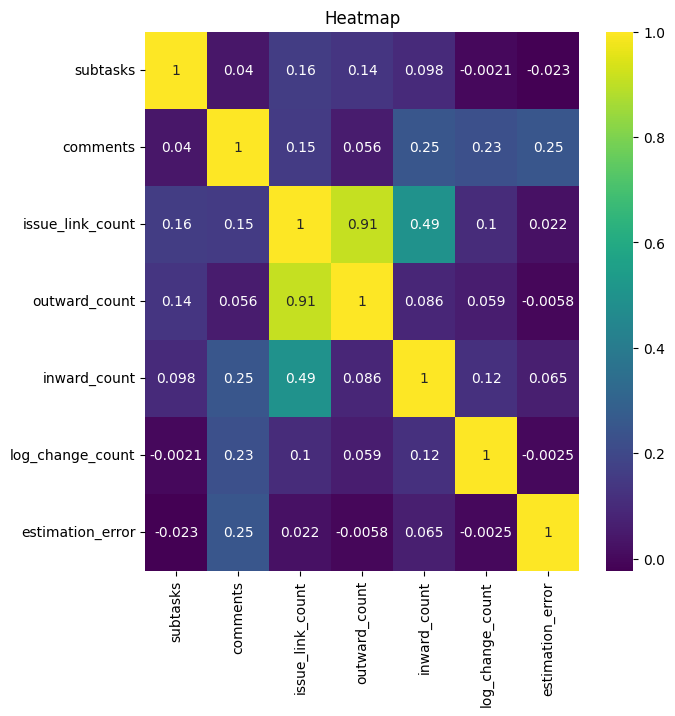

In [483]:
# numeric data correlation for overestimated
num_columns = r2_overestimated.select_dtypes(include='number')
# plotting heat map between numeric variables
fig, ax = plt.subplots(figsize=(7,7)) 
sns.heatmap(num_columns.corr(), annot=True, ax = ax, cmap='viridis')
plt.title('Heatmap')

Text(0.5, 1.0, 'Heatmap')

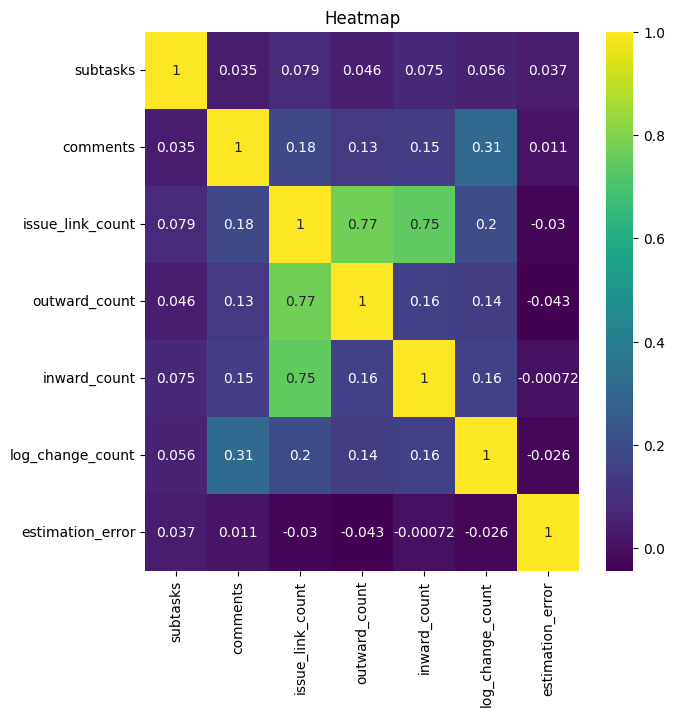

In [484]:
# numeric data underestimated
num_columns = r2_underestimated.select_dtypes(include='number')
# plotting heat map between numeric variables
fig, ax = plt.subplots(figsize=(7,7)) 
sns.heatmap(num_columns.corr(), annot=True, ax = ax, cmap='viridis')
plt.title('Heatmap')

### Perform CATEGORICAL PLOTS (IF NEDDED) for under/over estimations
### ==============

In [485]:
# for underestimated
temp = r2_underestimated.select_dtypes(include='O')
temp['estimation_error'] = r2_underestimated['estimation_error']

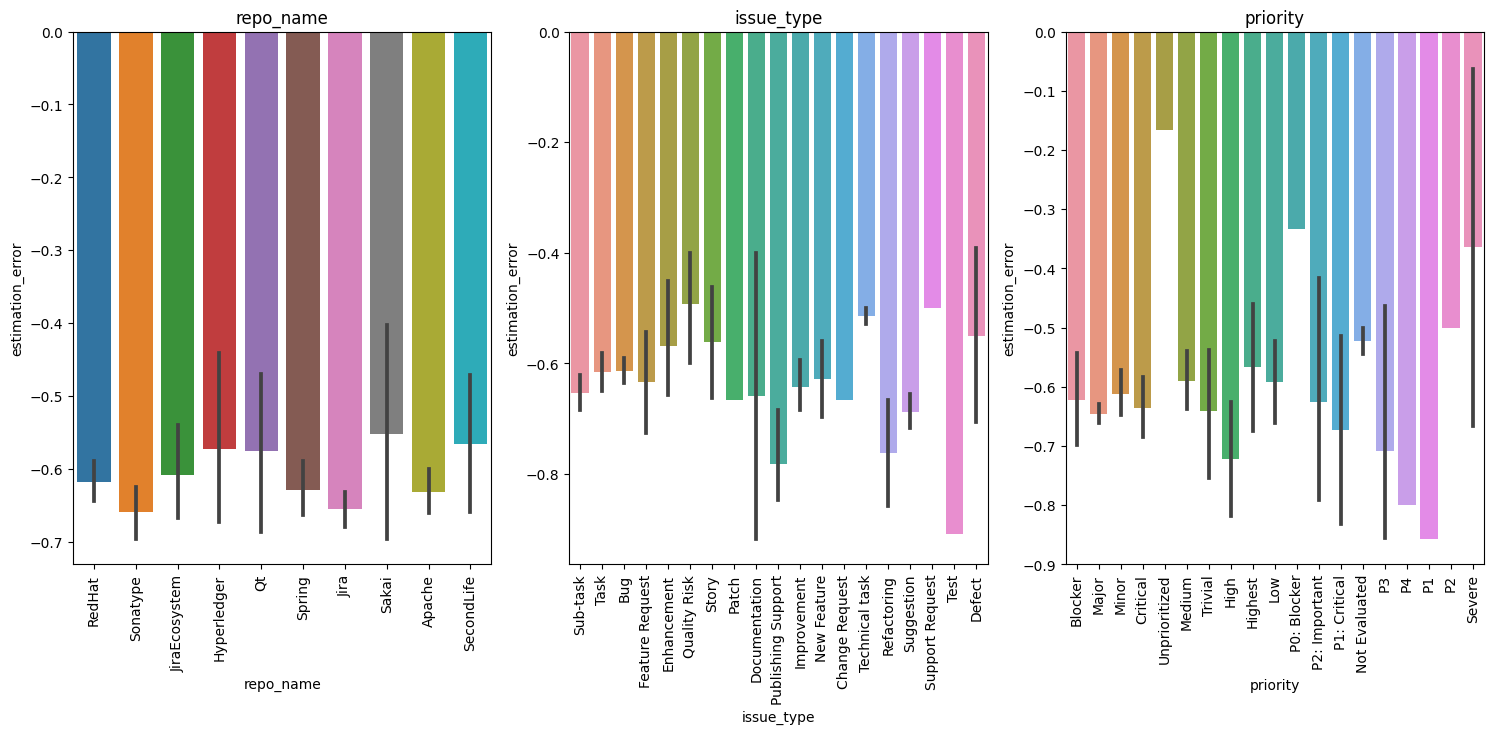

In [486]:
column_names = temp.columns[:-1]
fig = plt.figure(figsize=(20,20))
for i,col in enumerate(column_names):
    if len(temp[col].unique())/len(temp[col])<0.10 and len(temp[col].unique())>1:
        ax = fig.add_subplot(3,4, i+1)
        sns.barplot(x=col, y='estimation_error', data=temp, ax=ax)
        plt.xticks(rotation=90)
        plt.title(col)
fig.tight_layout()

In [487]:
# for overestimated
temp = r2_overestimated.select_dtypes(include='O')
temp['estimation_error'] = r2_overestimated['estimation_error']

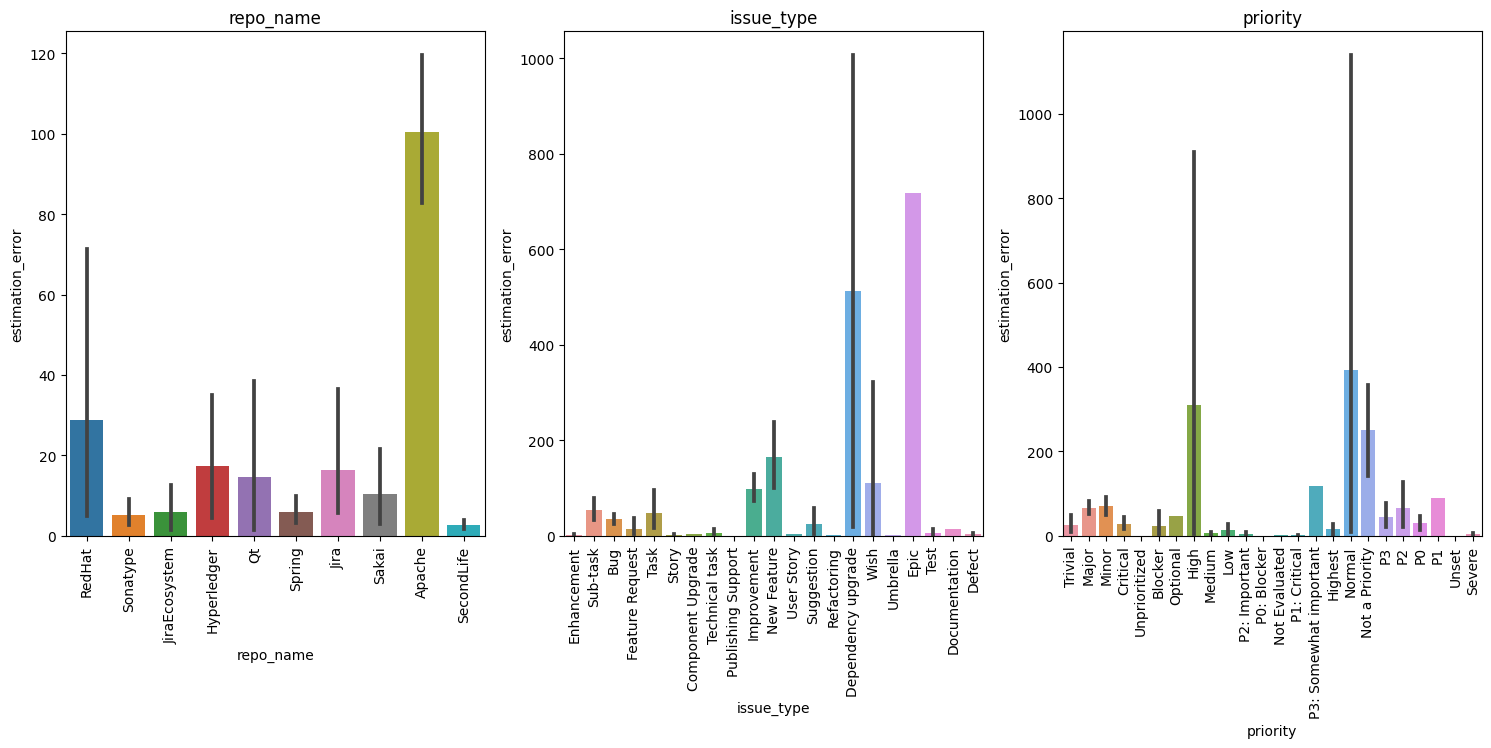

In [488]:
column_names = temp.columns[:-1]
fig = plt.figure(figsize=(20,20))
for i,col in enumerate(column_names):
    if len(temp[col].unique())/len(temp[col])<0.10 and len(temp[col].unique())>1:
        ax = fig.add_subplot(3,4, i+1)
        sns.barplot(x=col, y='estimation_error', data=temp, ax=ax)
        plt.xticks(rotation=90)
        plt.title(col)
fig.tight_layout()

In [420]:
# r2_numeric = r2_overestimated.select_dtypes(include='number').columns[:-1]
# for col in r2_numeric:
#     summary, results = rp.ttest(group1= r2_overestimated[col], group1_name= col,
#                             group2= np.log1p(r2_overestimated['estimation_error']), group2_name= "estimation_error")
#     print(summary,results)

# ============ END =====================

# EXTRA

#### Regression Analysis for overestimated

In [ ]:
# Dummy variable
categorical_columns = r2_overestimated.select_dtypes(include='O').columns[:-1]
df_encode = pd.get_dummies(data = r2_overestimated, prefix = 'OHE', prefix_sep='_',
               columns = categorical_columns,
               drop_first =True,
              dtype='int8')
df_encode = df_encode.drop('estimate_class',axis=1)

In [ ]:
df_encode

,subtasks,comments,issue_link_count,outward_count,inward_count,log_change_count,estimation_error,OHE_Hyperledger,OHE_Jira,OHE_JiraEcosystem,...,OHE_P1,OHE_P1: Critical,OHE_P2,OHE_P2: Important,OHE_P3,OHE_P3: Somewhat important,OHE_Severe,OHE_Trivial,OHE_Unprioritized,OHE_Unset
3,0,2,1,0,1,12.0,4.000000,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,4,1,0,1,12.0,6.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,4,3,1,2,12.0,0.666667,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,8,0,0,0,28.0,1.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,2,3,1,1,0,7.0,0.666667,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2469,0,3,0,0,0,18.0,3.838710,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2471,0,20,0,0,0,25.0,6.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2475,0,1,0,0,0,13.0,1.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2476,0,3,0,0,0,16.0,1.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.model_selection import train_test_split
# X = df_encode.drop('estimation_error',axis=1) # Independet variable
X = r2_overestimated.select_dtypes(include='number').iloc[:,:-1]
y = np.log1p(df_encode['estimation_error']) # dependent variable

In [ ]:
# Scikit Learn module
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X,y) # Note: x_0 =1 is no need to add, sklearn will take care of it.

#Parameter
sk_theta = [lin_reg.intercept_]+list(lin_reg.coef_)
columns = ['intersect:x_0=1'] + list(X.columns.values)
parameter_df = pd.DataFrame({'Columns':columns, 'theta':sk_theta})
parameter_df

,Columns,theta
0,intersect:x_0=1,2.136056e+00
1,subtasks,-4.159458e-02
2,comments,2.788631e-02
3,issue_link_count,1.914091e+12
4,outward_count,-1.914091e+12
5,inward_count,-1.914091e+12
6,log_change_count,2.518764e-05


In [ ]:
parameter_df['theta'] = parameter_df['theta'].astype('int64')
parameter_df.sort_values('theta')

,Columns,theta
4,outward_count,-1914090832878
5,inward_count,-1914090832878
1,subtasks,0
2,comments,0
6,log_change_count,0
0,intersect:x_0=1,2
3,issue_link_count,1914090832878


In [ ]:
for i in r2_underestimated.select_dtypes(include='O').columns:
    print(i,end=" ")

repo_name project_name issue_name priority assignee_id assignee_active_status creator_id creator_active_status reporter_id reporter_active_status estimate_class 

In [ ]:
for i in r2_underestimated.select_dtypes(include='number').columns:
    print(i,end=" ")

subtasks comments issue_link_count outward_count inward_count log_change_count estimation_error 

In [30]:
# # extract timespent and timeestimate for different software projects 
# r1_df_ls = []


# for coll in db.list_collection_names():
#     coll_name = coll
#     print(coll)
#     for data in db[coll].find():
#         issue_id = data['id']
#         timeestimate = -1
#         timespent = -1
#         try:
#             timeestimate = data['fields']['timeestimate']
#         except:
#             pass
#         if not timeestimate:
#             timeestimate=-1
            
#         try:
#             timespent = data['fields']['timespent']
#         except:
#             pass
#         if not timespent:
#             timespent=-1
        
#         r1_df_ls.append([coll,issue_id,timeestimate,timespent])

In [ ]:
# # try and test
# i = 0
# for temp in db["Hyperledger"].find():
#     issue_link_ls = list(temp['fields']['subtasks'])
#     if len(issue_link_ls)>0:
#         print(issue_link_ls)
#         print(temp['id'])
#         break
# # len(next(db["Hyperledger"].find())['fields']['issuelinks'])

In [ ]:
# # try and test
# i = 0
# for temp in db["Hyperledger"].find():
#     i+=1
#     if i==4:
#         print(temp['fields']['issuelinks'])
#         issue_link_ls = list(temp['fields']['issuelinks'])
#         issue_link_count = len(issue_link_ls)
#         outward_count = 0
#         inward_count = 0
#         for issue in issue_link_ls:
#             if "outwardIssue" in issue.keys():
#                 outward_count+=1
#             if "inwardIssue" in issue.keys():
#                 inward_count+=1
#         break
#         # len(temp['fields']['issuelinks'])>0:
# # len(next(db["Hyperledger"].find())['fields']['issuelinks'])

In [ ]:
# # try and test
# i = 0
# for temp in db["Hyperledger"].find():
#     issue_link_ls = list(temp['fields']['comments'])
#     if len(issue_link_ls)>0:
#         comment_authors = []
#         comment_datetime = []
#         updated_author = []
#         updated_datetime = []
        
#         for comment in issue_link_ls:
#             if "key" in comment['author'].keys():
#                 comment_authors.append(comment['author']['key'])
#                 comment_datetime.append(comment['created'])
#                 updated_author.append(comment['updateAuthor']['key'])
#                 updated_datetime.append(comment['updated'])
#             else:
#                 comment_authors.append(comment['author']['accountId'])
#                 comment_datetime.append(comment['created'])
#                 updated_author.append(comment['updateAuthor']['accountId'])
#                 updated_datetime.append(comment['updated'])
#         print(comment_authors,comment_datetime,updated_author,updated_datetime)
#         break
# # len(next(db["Hyperledger"].find())['fields']['issuelinks'])